# Basic Figures for Each Source
- included a few examples, but can run all once it looks good
- not too different from first few lines of each source notebook, but a bit simpler
- I and V band LCs
- color-mag with time stamps (another option that I've tried is also putting the interpolated I points, with time colors, onto the LC)
    - or plot V-I vs. time
- three basic periodograms with fixed bounds for each source
    - can inset periodogram searching closer to established orbital period
    - searches each OGLE epoch
- two more searches closer to established period, if there is one
    - one without detrending, one with
    - can add (or add option) to separate into years or parts with good sampling
    
- To do
    - ~**folded LCs as hisstep rather than scatter plots?**~
        - **but need to discuss error**
    - output Corbet prediction based on spin period
    - add option to save figures (save all or particular ones)
    - ~make table that can be read in and out of jupyter with important values (periods, mag ranges, etc.)~
    - ~put peaks from periodograms into dictionary automatically so that not overwritten~
    - break up into functions and then call them all in basic, for better readability
    - correct alias approach?
        - ~but expand function to more automatically evaluate multiple peaks (i.e. array of peaks)~ and then use for more useful output
    - FRED vs. sinusoidal using FWHM and PA of mean folded LC
        - FRED strong indicator of orbital while sinusoidal means inconclusive (Bird)
        - impact of amplitude and shorter period?

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
# from lmfit.models import GaussianModel
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

In [2]:
cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

In [3]:
full[:3]

src_n,OGLE,RA_OGLE,DEC_OGLE,ra_deg,dec_deg,perr,period,Porb,_RAJ2000_1,_DEJ2000_1,__M2002_,Vmag_1,Separation_1,_RAJ2000_2,_DEJ2000_2,Vmag_2,recno,Separation
int64,str38,str11,str11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64
1,OGLE,RA,DEC,19.271511,-73.443405,0.5,0.717,3.892,19.27120833333333,-73.44333333333334,77458,13.15,0.4041071611446303,19.271369999999997,-73.44318999999999,13.152,5068334,0.7879504646408463
2,SMC732.03 \#3540,01:21:40.61,-72:57:30.9,20.41893,-72.95907,2.0,2.165,84.0,20.418999999999993,-72.95847222222221,80352,14.28,2.147142505236131,--,--,--,--,--
3,SMC720.17 \#50,00:54:33.44,-73:41:01.3,13.639167,-73.68364,0.8,2.37,18.38,13.639333333333331,-73.68369444444444,30492,14.51,0.2597014565010407,13.639544999999995,-73.68356999999999,14.729,2675272,0.4570936647419033


# Make Table for Important Quantities
- **comment out once written out the first time and instead read in and write as needed**

In [4]:
#summary table: include many but not all rows from full
# up to sep from full table

# pandas DataFrame b/c easier with data types
# summ = pd.DataFrame(columns=['src_n','ra_deg','dec_deg','spin period','perr','est. period','sep',
#                     'name','mean I','stdev I','max I','min I','I range','mean V','stdev V','max V','min V','V range',
#                    'est. period method','best period','best superorbital','other period','period shape','big dip',
#                    'orbital cont','superorbital cont','mult superorbital','changing superorbital amp',
#                    'redder when brighter','I V-I corr','V V-I corr','I V-I slope','I V-I int','V V-I slope','V V-I int',
#                     'V-I transition','Type II amp','note'])
#separate tables for all significant peaks

In [5]:
#read in summary table, which was first initialized above
summ = pd.read_csv('summtab.csv') #can decide whether to switch indexing to src_n

In [6]:
summ.head()

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,redder when brighter,I V-I corr,V V-I corr,I V-I slope,I V-I int,V V-I slope,V V-I int,V-I transition,Type II amp,note
0,1,19.271511,-73.443405,0.717,0.5,3.892,0.404107,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,20.418930,-72.959070,2.165,2.0,84.000,2.147143,NaN,14.379506,0.356251,...,yes,-0.98468,-0.954668,-2.314422,14.44689,-1.314422,14.44689,NaN,NaN,NaN
2,3,13.639167,-73.683640,2.370,0.8,18.380,0.259701,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,14.797429,-71.645960,2.763,7.5,82.370,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,12.913330,-72.284330,4.780,1.4,0.000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**some name explanations** -- decide how to do categorical variables (e.g. 'yes' or 'no')
- est period method: method for determination of established period (X-ray or optical)
- superorbital cont: continuous superorbital trend (rather than base value with flares) -- same goes for orbital cont
- mult. superorbital: multiple superorbital periods (i.e. epochs with different periods)
- I V-I corr, V V-I corr: correlation coefficient in each plot (negative is redder when brighter and closer to one less scatter)
    - can discuss value to use; for now: np.corrcoeff
    - for now, 'yes' to redder when brighter iff both coeffs less than -0.5
    - only 'no' if coeff greater than 0.5
    - otherwise: 'check'
- I V-I slope, I V-I int: coefficients for best fit line of interp I vs. V-I
- V-I transition: for now, any sort of separate features or transition
- Type II amp: amplitude (max-~min) of Type II outburst if there is one
    - once modeling, add FWHM (same for other flares)
- note: any quick notes (e.g. important to 'see summary')

> - **future: add flare parameters from fitting (e.g. amplitude, FWHM, quantified asymmetry**

In [7]:
summ.columns

Index(['src_n', 'ra_deg', 'dec_deg', 'spin period', 'perr', 'est. period',
       'sep', 'name', 'mean I', 'stdev I', 'max I', 'min I', 'I range',
       'mean V', 'stdev V', 'max V', 'min V', 'V range', 'est. period method',
       'best period', 'best superorbital', 'other period', 'period shape',
       'big dip', 'orbital cont', 'superorbital cont', 'mult superorbital',
       'changing superorbital amp', 'redder when brighter', 'I V-I corr',
       'V V-I corr', 'I V-I slope', 'I V-I int', 'V V-I slope', 'V V-I int',
       'V-I transition', 'Type II amp', 'note'],
      dtype='object')

In [8]:
#get all source numbers
nums = cross['src_n']

In [9]:
# summ['src_n'] = full['src_n']
# summ['ra_deg'] = full['ra_deg']
# summ['dec_deg'] = full['dec_deg']
# summ['spin period'] = full['period']
# summ['perr'] = full['perr']
# summ['est. period'] = full['Porb']
# summ['sep'] = full['Separation_1']

In [10]:
summ[summ['src_n']==7]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,redder when brighter,I V-I corr,V V-I corr,I V-I slope,I V-I int,V V-I slope,V V-I int,V-I transition,Type II amp,note
6,7,15.722455,-72.74299,6.85,0.5,21.9,0.421283,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Initialize Dictionary for Tables of Peaks in Periodograms
- each source has peaks from three periodograms to save, in tables with period and peak


In [11]:
#initialize dictionary with a list for each source number
#that list will then be a list of three tables
peak_dict = dict.fromkeys(nums, [])

In [12]:
peak_dict[7] 

[]

In [13]:
def findalias(pk,retall=False,retn=False,nrange=20):
    '''Draft function to find aliases
    Input a peak table (in which case best period is used) or period float or int
    Update such that array passed in to try out aliasing of many peaks without a loop'''
    #pass in specific period value
    if type(pk)==float or type(pk)==int: bp = pk
    #pass in table with period and power -- take top period
    else: bp = float(pk['period'][:1])
    n = np.arange(1,nrange)
    #alias frequency is sampling (1/1day) times +/- frequency passed in 
    f = n + 1/bp #but when not sinusoidal another coefficient rather than 1/bp (i.e. m/bp)
    #alias peak
    ap = np.abs(1/f)
    #change any inf to zero
    ap[ap==np.inf]=0
    if retall and retn: 
        #return all periods above one day and associated n
        return n[np.where(ap>1)],ap[ap>1]
    elif retall: return ap[ap>1]
    elif retn: return n[np.argmax(ap)],np.max(ap)
    return np.max(ap)

In [61]:
def aliasarr(arr,nrange=1,cutzero=True):
    '''Find aliases above 1 (or given value mina) using array of periods
    arr: array of period (peaks)
    nrange: maximum n to use in alias calculation
            n's used: -1*nrange to nrange'''
    n = np.arange(-1*nrange,nrange+1) #includes zero so returned array will include periods passed in
    #repeat range of n for # of periods passed in
    nt = np.tile(n,(len(arr),1))
    nt = np.swapaxes(nt,0,1)
    a = np.tile(arr,(len(n),1))
    farr = nt + 1/a 
    parr = np.abs(1/farr)
    #cut out array of original periods (from n=0)
    if cutzero:
        parr = np.concatenate([parr[:nrange],parr[nrange+1:]])
    return parr

see examples of aliasarr() after use of basic function
- can use with periods from peak_dict

examples with findalias, which identifies alias periods for just one period

In [18]:
findalias(2.6,retall=True)

array([], dtype=float64)

In [19]:
findalias(8,retall=True) #in this case, returns int n and period

array([], dtype=float64)

In [20]:
findalias(8.89,retn=True,retall=True) 

(array([], dtype=int64), array([], dtype=float64))

In [65]:
def findbeat(p1,p2):
    '''Return beat period given two periods'''
    return 1/np.abs(1/p1 - 1/p2)

In [66]:
findbeat(.45,80.2)

0.452539184952978

# Summary Functions
- main function is basic(), two cells below
- addtotable() called in basic to populate summary table

In [23]:
def addtotable(iband,vband,tab,num,interp):
    '''Automatically update some columns of summ table
    Called at the end of basic()'''
    #row to update
    row = tab[tab['src_n']==num]
    #put in mean, stdev, max, min I and V band values
    row['mean I'] = np.mean(iband['I mag'])
    row['stdev I'] = np.std(iband['I mag'])
    row['min I'] = np.min(iband['I mag'])
    row['max I'] = np.max(iband['I mag'])
    row['I range'] = row['max I'] - row['min I']
    #repeat for V band
    row['mean V'] = np.mean(vband['V mag'])
    row['stdev V'] = np.std(vband['V mag'])
    row['min V'] = np.min(vband['V mag'])
    row['max V'] = np.max(vband['V mag'])
    row['V range'] = row['max V'] - row['min V']
    
    #correlation coefficients for Iint vs. V-I and V vs. V-I 
    icorr = np.corrcoef(vband['V mag']-interp,interp)[1][0]
    row['I V-I corr'] = icorr
    vcorr = np.corrcoef(vband['V mag']-interp,vband['V mag'])[1][0]
    row['V V-I corr'] = vcorr
    
    #redder when brighter(update criteria as needed)
    if icorr < -0.5 and vcorr < -0.5: row['redder when brighter'] = 'yes'
    elif icorr > 0.5 and vcorr > -0.5: row['redder when brighter'] = 'no'
    else: row['redder when brighter'] = 'check'
        
    #best fit lines to Iint vs. V-I and V vs. V-I 
    vi = vband['V mag']-interp
    imod = np.polyfit(vi,interp,1)
    #use coefficients to make string of equation
    #can decide if other format better and easier to use when pulling from table (e.g. breaking up into slope and int)
    row['I V-I slope'] = imod[0]
    row['I V-I int'] = imod[1] 
    #can add full = True to np.polyfit to also get sum of squares of residuals
    
    vmod = np.polyfit(vi,vband['V mag'],1)
    row['V V-I slope'] = vmod[0]
    row['V V-I int'] = vmod[1] 

    #update table
    tab[tab['src_n']==num] = row
    
    #calculate I vs. V-I correlation to determine if redder when brighter
    #for now, redder when brighter just based on I vs. V-I, not both
    return 

In [24]:
def basic(index,inset=True,pbins=10,det=False,color=pink,sigmas=[100,30,20],dists=[100,100,30],medlim=True,rettabs=False):
    '''Carry out basic anaylis of a single source
    To do: put peak frames into dictionary based on source number (as part of function rather than return statement)
    medlim: limits on detrended phase-fold 0.06 from median rather than showing all data points
    rettabs: return three peak tables, rather than adding them to dictionary peak_dict'''
    #get source number using index
    srcn = nums[index]
    #grab row for source number from full table
    row = full[full['src_n']==srcn]
    print('Source number: '+str(srcn))
    print('RA,Dec (deg): '+ str(float(row['ra_deg']))+', '+str(float(row['dec_deg'])))
    print('Established period: '+str(float(row['Porb'])))
    print('NS spin period: '+str(float(row['period'])))
    #check on this
    print('Separation: '+str(float(row['Separation_1'])))
    
    orb = float(row['Porb'])
    
    #get I and V band LCs
    ilist,vlist = o.getIV(srcn,cross,plot=True,zooms=False,figsize=(8,4),mult=(3,8),offset=10,stack=False)
    iband,vband = vstack(ilist),vstack(vlist)
    
    #color-mag plots
    interp = o.colormag(iband,vband,ctime=True,retint=True,figsize=(9,8)) 
    
    #get start and end dates
    stdate = iband['MJD-50000'][:1]
    endate = iband['MJD-50000'][-1:]
    trange = endate-stdate
    #three ranges for periodograms: less than 2, 2-200, 200-4000?
    #for each, save main peaks
    freq1,power1,bp1 = o.periodogram(iband,minp=0.1,maxp=2,more=True,plot=False)
    pf1 = o.findpeaks(freq1,power1,sigma=sigmas[0],distance=dists[0],pkorder=True)
    
    freq2,power2,bp2 = o.periodogram(iband,minp=2.01,maxp=200,more=True,plot=False)
    pf2 = o.findpeaks(freq2,power2,sigma=sigmas[1],distance=dists[1],pkorder=True)
    if orb>0:
        near = pf2[np.abs(orb-pf2['period'])<orb/10]
        i = 0
        #adjust distance and sigma until nearby peak identified
        while len(near)<1 and i<sigmas[1]/5:
            pf2 = o.findpeaks(freq2,power2,sigma=sigmas[1]-i*5,distance=dists[1]-i*5,pkorder=True)
            near = pf2[np.abs(orb-pf2['period'])<orb/10]
            i+=1
    freq3,power3,bp3 = o.periodogram(iband,minp=200,maxp=trange/3,more=True,plot=False)
    pf3 = o.findpeaks(freq3,power3,sigma=sigmas[2],distance=dists[2],pkorder=True)
    #plot side-by-side
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    #plot each periodogram with best period in text
    ax[0].plot(1/freq1,power1,color='black')
    ax[0].text(0.1+(2-0.1)/2,0.8*np.max(power1),f'best: {bp1:.2f}')

    ax[1].plot(1/freq2,power2,color='black')
    ax[1].text(2.01+(200-2.01)/200,0.8*np.max(power2),f'{bp2:.2f}')
    
    ax[2].plot(1/freq3,power3,color='black')
    ax[2].text(200+(trange/3-200)/2,0.8*np.max(power3),f'{bp3:.2f}')

    ax[0].set_ylabel('LS Power',fontsize=14)
    ax[0].set_xlabel('Period (days)',fontsize=14)
    #inset periodogram search closer to established period; one periodogram per OGLE epoch
    if not np.isnan(orb) and inset:
        ax[1].axvline(orb,color='darkseagreen',alpha=0.4)
        #inset search closer to orbital period for each OGLE epoch
        axins = inset_axes(ax[1], width=1.4, height=1.4,loc='upper right',borderpad=0.4)
        colors = ['navy','maroon','darkgreen']
        labels = ['OII','OIII','OIV']
        if len(ilist)==2: labels=labels[1:]
        c = 0
        low = orb-orb/10
        up = orb+orb/10
        for i in ilist:
            f,p,bp = o.periodogram(i,minp=low,maxp=up,more=True,plot=False)
            axins.plot(1/f,p,color=colors[c],label=labels[c])
            axins.set_yticks([])

            c+=1
        axins.axvline(orb,color='darkseagreen',alpha=0.4)
        axins.legend()
        
    #compare phase-fold of best peak near orbital period and established orbital period
    if orb>0:
        plt.rcParams['lines.linewidth'] = 2

        print('Phase-folding with established orbital period and highest peak within five days of that value...')
        orb = np.float(orb)
        np1 = float(near['period'][:1]) #highest peak
        fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
        plt.subplots_adjust(wspace=0.04)
        ax[0].errorbar(iband['MJD-50000']%orb,iband['I mag'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=4,color=color,label=f'est. pd: {orb}',zorder=1,alpha=0.4)
        ax[0].errorbar(orb+iband['MJD-50000']%orb,iband['I mag'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=4,color=color,zorder=1,alpha=0.4)
        mid,avg = o.meanphase(iband,orb,pbins=pbins,det=det,double=True)
        ax[0].plot(mid,avg,color='black',zorder=10)

        
        maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
        ax[0].set_ylim(maxi+.02,mini-.02)
        
        ax[1].errorbar(iband['MJD-50000']%np1,iband['I mag'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=3,color=color,label=f'LS peak near est.: {np1:.2f}',zorder=1,alpha=0.4)
        ax[1].errorbar(np1+iband['MJD-50000']%np1,iband['I mag'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=3,color=color,zorder=1,alpha=0.4)
        mid,avg = o.meanphase(iband,np1,pbins=pbins,det=det,double=True)

        ax[1].plot(mid,avg,color='black',zorder=10)
        
        ax[0].legend(loc='lower left')
        ax[1].legend(loc='lower left')
        ax[0].set_ylabel('I mag')
        ax[0].set_xlabel('Phase')
        
        #repeat but after detrending
        print('Repeating periodogram and phase-fold after detrending')
        window = np.arange(orb*2-int(orb/2),orb*2+11,2,dtype='int16')
        if window[0]%2 == 0: window += 1
        fig,ax = plt.subplots(1,4,figsize=(20,4))
        plt.subplots_adjust(wspace=0.25)

        bps = []
        maxpow = []
        for w in window:
            o.detrend(iband,window=w)
            freq,power,bp = o.periodogram(iband,minp=low,maxp=up,det=True,more=True,plot=False)
            ax[0].plot(1/freq,power,color='black')
            bps.append(bp)
            maxpow.append(np.max(power))
        #final detrend with low value
        finwin = int(orb*2-int(orb/2))
        if finwin%2==0: finwin+=1
        o.detrend(iband,window=finwin)
        print(f'Window shown in phase-fold: {finwin}')

        #highest-powered best period
        np1 = bps[np.argmax(maxpow)]
        ax[0].axvline(orb,color='darkseagreen',alpha=0.4,label=f'est. pd: {orb}')
        ax[0].legend()
        im = ax[3].scatter(window,bps,c=maxpow)
        fig.colorbar(im,label='Power')
        ax[3].axhline(orb,color='darkseagreen',alpha=0.4)
        
        #now phase-fold
        ax[1].errorbar(iband['MJD-50000']%orb,iband['I detrend'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=2,color=color,alpha=0.4,label=f'est. pd: {orb}',zorder=1)
        ax[1].errorbar(orb+iband['MJD-50000']%orb,iband['I detrend'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=2,color=color,alpha=0.4,zorder=1)
        mido,avgo = o.meanphase(iband,orb,pbins=pbins,det=True,double=True)
        ax[1].plot(mido,avgo,color='black',zorder=10)

        
        maxi,mini = np.max(iband['I detrend']),np.min(iband['I detrend'])
        medi = np.median(iband['I detrend'])
        #cut out outliers
        if medlim:
            ax[1].set_ylim(medi+.06,medi-.06)
            ax[2].set_ylim(medi+.06,medi-.06)
        else:
            ax[1].set_ylim(maxi+.01,mini-.01)
            ax[2].set_ylim(maxi+.01,mini-.01)

        ax[2].errorbar(iband['MJD-50000']%np1,iband['I detrend'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=2,alpha=0.4,color=color,label=f'LS peak near est.: {np1:.2f}',zorder=1)
        ax[2].errorbar(np1+iband['MJD-50000']%np1,iband['I detrend'],yerr=iband['I mag err'],linestyle='none',marker='o',markersize=2,color=color,zorder=1,alpha=0.4)
        midn,avgn = o.meanphase(iband,np1,pbins=pbins,det=True,double=True)

        ax[2].plot(midn,avgn,color='black',zorder=10)
        
        ax[1].legend(loc='lower left')
        ax[2].legend(loc='lower left')
        ax[1].set_ylabel('I detrended')
        ax[1].set_xlabel('Phase')   
        ax[0].set_ylabel('LS Power')
        ax[0].set_xlabel('Period (days)')
        ax[3].set_ylabel('Peak Period')
        ax[3].set_xlabel('Detrending Window')
        
    #print useful quantites
    print('\n')
    print('max I band: ',np.max(iband['I mag']))
    print('min I band: ',np.min(iband['I mag']))
    print('I range: ',np.max(iband['I mag'])-np.min(iband['I mag']))
    print('I stdev: ',np.std(iband['I mag']))

    
    print('max V band: ',np.max(vband['V mag']))
    print('min V band: ',np.min(vband['V mag']))
    print('V range: ',np.max(vband['V mag'])-np.min(vband['V mag']))
    print('V stdev: ',np.std(vband['V mag']))
    
    #add values to table
    addtotable(iband,vband,summ,srcn,interp)

    if rettabs: return pf1,pf2,pf3
    else:
        peak_dict[srcn] = [pf1,pf2,pf3]

# Phase-Folded Data as Step Plots: Function and Example
- mean from each bin
- error is standard deviation in that bin, but yields very large error bars usually...

In [85]:
def phasestep(iband,pd,pbins,det=False,med=False,double=True,color='black',err=True):
    '''Step function for phase-folded data
    To do: ability to plot on input set of axes rather than creating new plot'''
    #use mean phase to get middle values of bins and means in each bin
    mid,avg,std = o.meanphase(iband,pd,pbins=pbins,det=det,med=med,double=double,stdev=True)
    plt.step(mid,avg,where='mid',color=color)
    #add errors as one sigma
    if err: plt.errorbar(mid,avg,yerr=std,color=color,marker='',linestyle='none',alpha=0.4)
    #flip y axis 
    maxa,mina = np.max(avg),np.min(avg)
    if err:
        maxa += std[np.argmax(avg)]
        mina -= std[np.argmin(avg)]
    plt.ylim(maxa+.01,mina-.01)
    plt.ylabel('I mag')
    plt.xlabel('Phase (days)')

In [86]:
iband,vband = o.getIV(22,cross,plot=False,zooms=False,figsize=(8,4),mult=(3,8),offset=10,stack=True)

detrending decreases error bars
- important to also consider how shape (amp, FWHM, PA) may change with detrending

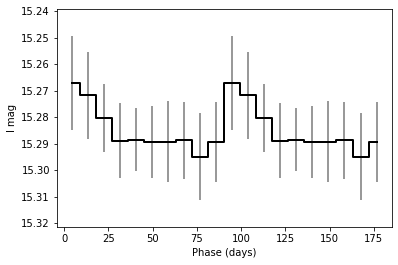

In [102]:
reload(o)
o.detrend(iband,window=111)
phasestep(iband,90.5,10,det=True,err=True)

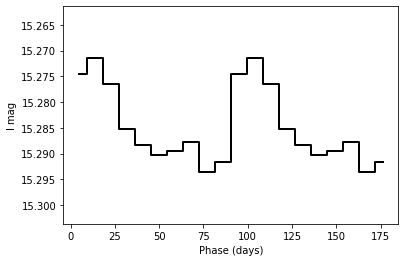

In [103]:
#taking away errors and looking at LS best rather than established period
phasestep(iband,90.44,10,det=True,err=False) #FRED shape

# Examples of Source Summaries

Source number: 2
RA,Dec (deg): 20.41893, -72.95907
Established period: 84.0
NS spin period: 2.165
Separation: 2.147142505236131
I and V-I correlation: -0.9846799925699677
V and V-I correlation: -0.9546678612457401
Phase-folding with established orbital period and highest peak within five days of that value...
Repeating periodogram and phase-fold after detrending
Window shown in phase-fold: 127


max I band:  15.06
min I band:  13.983
I range:  1.077
I stdev:  0.3562511738415938
max V band:  14.753
min V band:  14.195
V range:  0.5579999999999998
V stdev:  0.1525440976517776


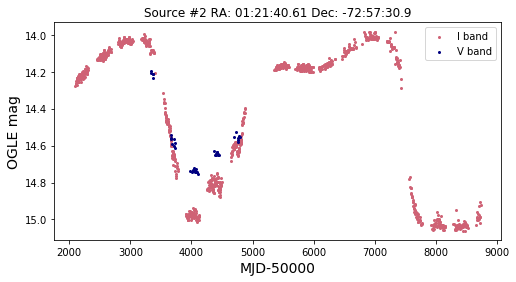

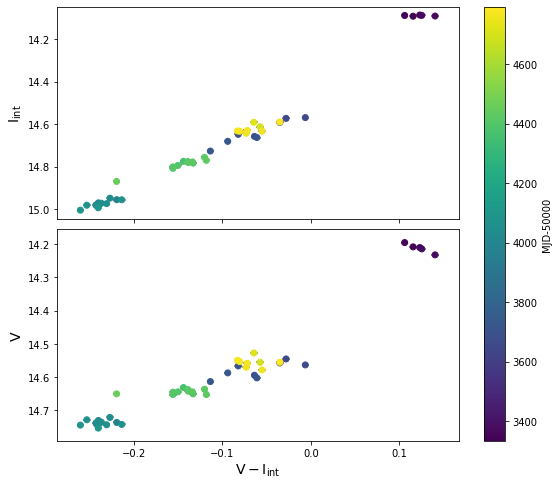

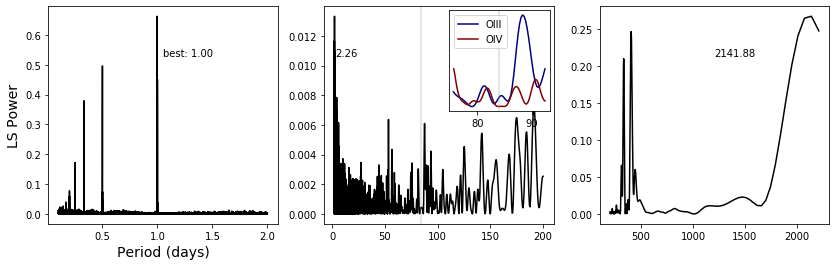

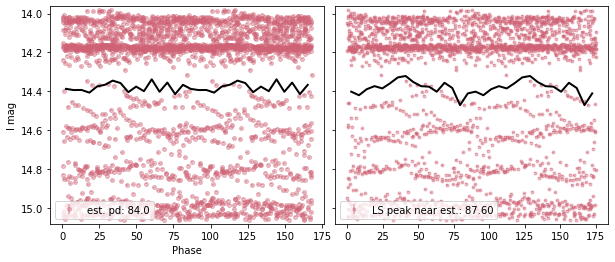

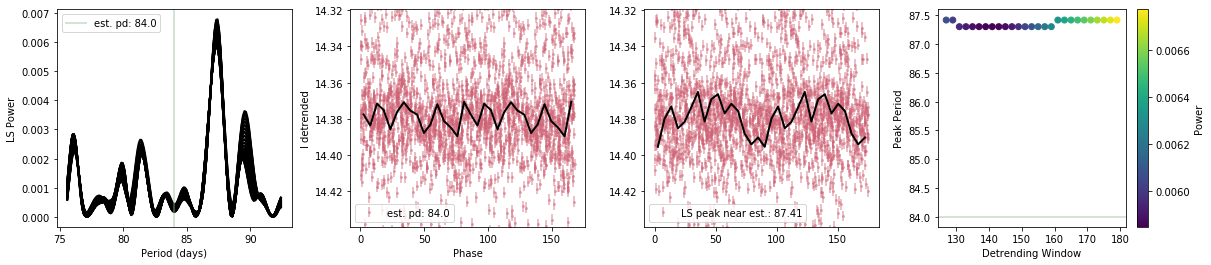

In [25]:
reload(o)
#outputs text and figs, adds to summary table, and puts three peak tables into peak_dict (with the key being source number)
basic(0,pbins=16)

In [26]:
summ[:3] #succesfully updated table

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,redder when brighter,I V-I corr,V V-I corr,I V-I slope,I V-I int,V V-I slope,V V-I int,V-I transition,Type II amp,note
0,1,19.271511,-73.443405,0.717,0.5,3.892,0.404107,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,20.418930,-72.959070,2.165,2.0,84.000,2.147143,NaN,14.379506,0.356251,...,yes,-0.98468,-0.954668,-2.314422,14.44689,-1.314422,14.44689,NaN,NaN,NaN
2,3,13.639167,-73.683640,2.370,0.8,18.380,0.259701,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
peak_dict[2][0][:3] #indexing is source number followed by table number (0 from 0,1,2) and then rows

,period,power
2,0.997522,0.662689
6,0.499380,0.495951
1,0.999730,0.451272


In [63]:
#first few periods from second periodogram
arrt = aliasarr(peak_dict[2][1][:5]['period'],nrange=1,cutzero=False)
arrt

array([[1.79211481, 1.87511549, 1.85251502, 1.6978947 , 1.52124775],
       [2.26244325, 2.14270632, 2.17299986, 2.43288092, 2.9184735 ],
       [0.69348126, 0.68180291, 0.68484083, 0.70869948, 0.74479858]])

In [62]:
#takes out array where n = 0 (so just original periods given)
arrt = aliasarr(peak_dict[2][1][:5]['period'],nrange=1)
arrt

array([[1.79211481, 1.87511549, 1.85251502, 1.6978947 , 1.52124775],
       [0.69348126, 0.68180291, 0.68484083, 0.70869948, 0.74479858]])

In [64]:
#periods from third periodogram
arrt = aliasarr(peak_dict[2][2][:5]['period'],nrange=2)
arrt #predicts the alias at .9975 and .49938

array([[0.50011675, 0.50061825, 0.50075417],
       [1.0004671 , 1.00247606, 1.00302123],
       [0.99953334, 0.99753614, 0.99699691],
       [0.49988331, 0.49938327, 0.4992481 ]])

Source number: 22
RA,Dec (deg): 17.785799, -73.279465
Established period: 90.5
NS spin period: 31.03
Separation: 0.23502474081500227
I and V-I correlation: -0.9136655015697079
V and V-I correlation: -0.42999300788629347
Phase-folding with established orbital period and highest peak within five days of that value...
Repeating periodogram and phase-fold after detrending
Window shown in phase-fold: 137


max I band:  15.429
min I band:  15.113
I range:  0.3160000000000007
I stdev:  0.05909596374360111
max V band:  15.576
min V band:  15.404
V range:  0.1720000000000006
V stdev:  0.025547074471517377


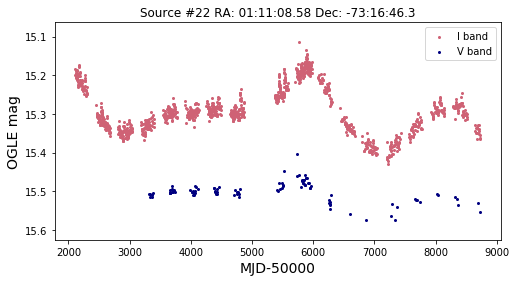

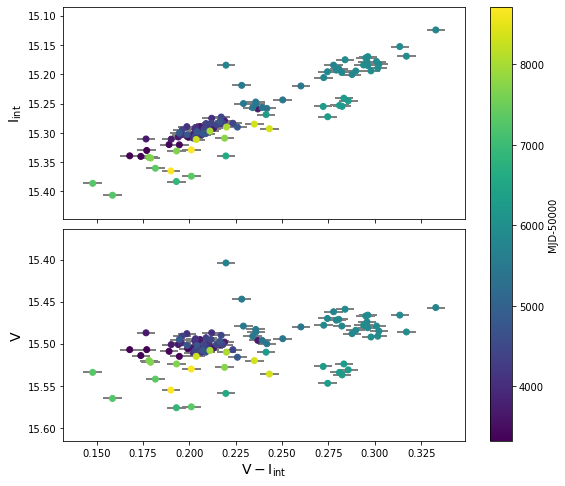

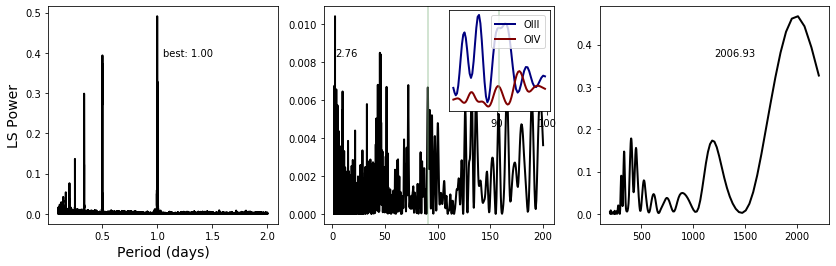

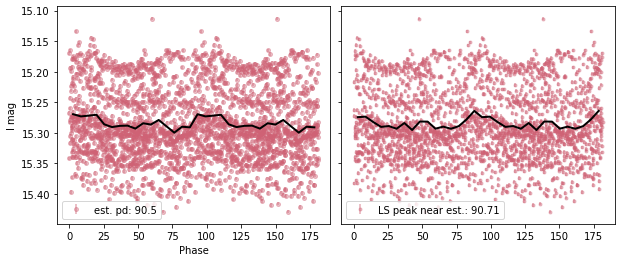

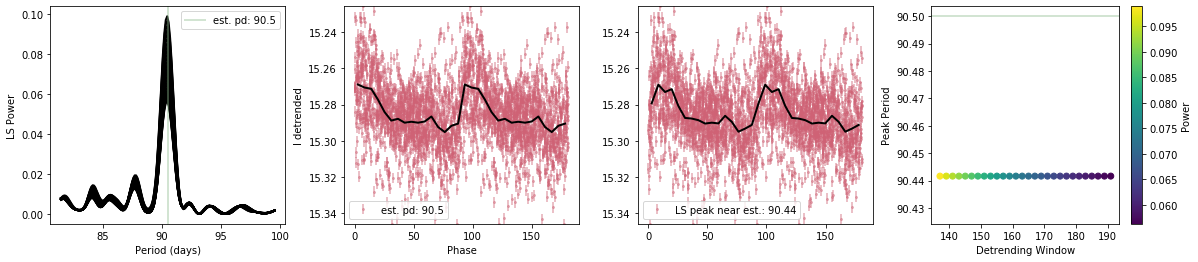

In [28]:
basic(17,pbins=16)

In [29]:
summ[20:25]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,redder when brighter,I V-I corr,V V-I corr,I V-I slope,I V-I int,V V-I slope,V V-I int,V-I transition,Type II amp,note
20,22,17.785799,-73.279465,31.03,0.73,90.50,0.235025,NaN,15.284734,0.059096,...,check,-0.913666,-0.429993,-1.268844,15.563178,-0.268844,15.563178,NaN,NaN,NaN
21,23,13.480083,-72.446030,46.63,0.60,137.36,0.647529,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,24,13.734498,-72.446460,59.07,0.59,62.10,1.090329,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,25,16.802626,-72.592720,65.78,0.87,110.60,0.295919,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,26,12.263891,-72.847824,74.67,0.62,33.38,0.181334,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Source number: 31
RA,Dec (deg): 13.35, -72.454445
Established period: 103.6
NS spin period: 138.0
Separation: 1.1629397680176692
I and V-I correlation: -0.9926580142506026
V and V-I correlation: -0.9549740785369608
Phase-folding with established orbital period and highest peak within five days of that value...
Repeating periodogram and phase-fold after detrending
Window shown in phase-fold: 157


max I band:  16.374
min I band:  15.71
I range:  0.6639999999999979
I stdev:  0.14025190573691002
max V band:  16.287
min V band:  16.008
V range:  0.2789999999999999
V stdev:  0.06042549284753631


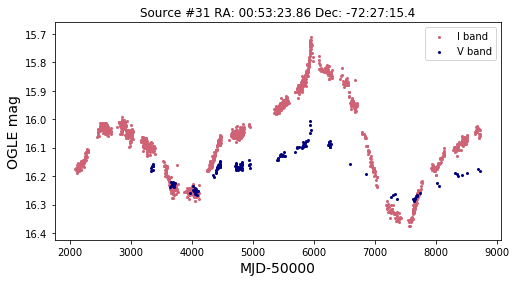

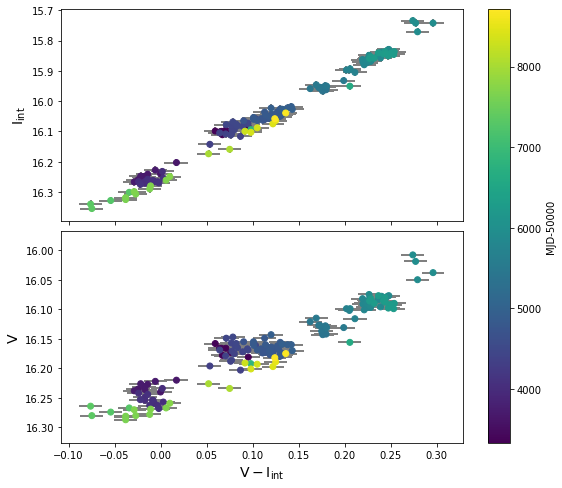

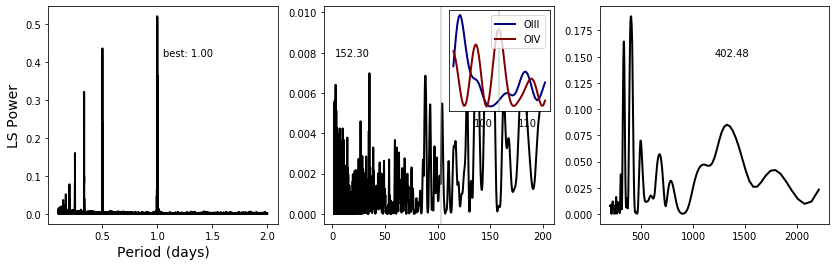

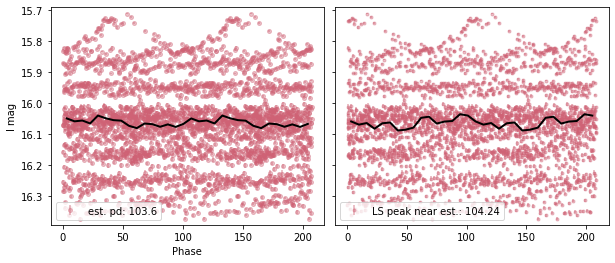

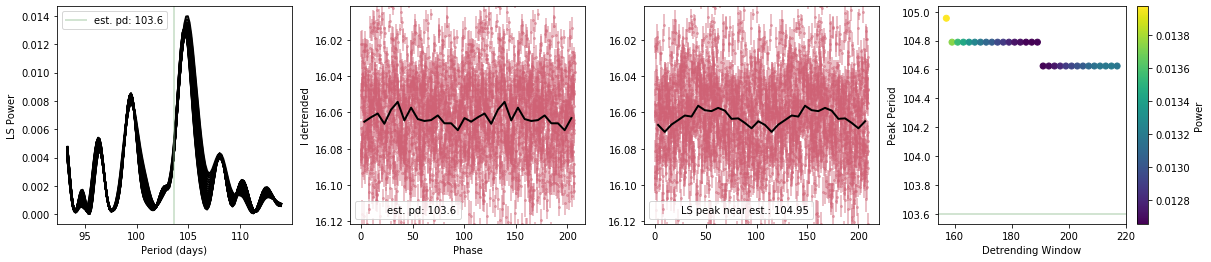

In [30]:
basic(25,pbins=16)

Source number: 64
RA,Dec (deg): 15.906292, -72.0258
Established period: nan
NS spin period: 1323.0
Separation: 0.3875389193454174
I and V-I correlation: -0.4388904144939015
V and V-I correlation: 0.5195263979783094


max I band:  14.665
min I band:  14.479
I range:  0.18599999999999994
I stdev:  0.02984407479612393
max V band:  14.727
min V band:  14.562
V range:  0.16500000000000092
V stdev:  0.03415353164324986


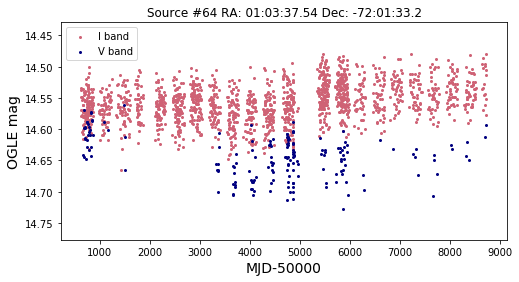

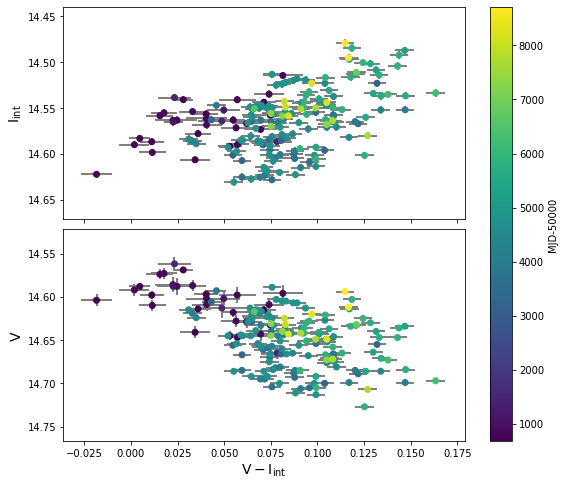

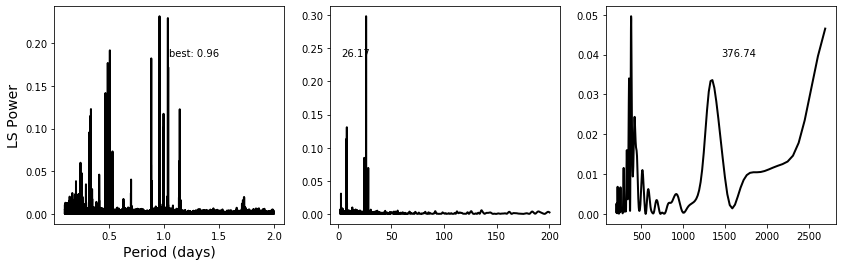

In [31]:
#example of source with no established period
basic(54,pbins=16)

In [32]:
summ[summ['src_n']==64]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,redder when brighter,I V-I corr,V V-I corr,I V-I slope,I V-I int,V V-I slope,V V-I int,V-I transition,Type II amp,note
59,64,15.906292,-72.0258,1323.0,1.1,0.0,0.387539,NaN,14.557341,0.029844,...,check,-0.43889,0.519526,-0.445474,14.599173,0.554526,14.599173,NaN,NaN,NaN


In [33]:
#write table back out
summ.to_csv('summtab.csv',index=False)